In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as sps

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import NMF
from sklearn.cross_decomposition import CCA, PLSRegression, PLSSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict
from pyuoi.UoINMF import UoINMF
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import PolynomialFeatures, minmax_scale
from sklearn.pipeline import make_pipeline

from hdbscan import HDBSCAN
import sys

from collections import Counter
import seaborn as sns
from activ.nmf.viz import weights_clustermap, bases_heatmap, get_labels
import activ

In [42]:
def _check_X_y(x, y):
    x_ret = x
    y_ret = y
    if len(x.shape) == 1:
        x_ret = x.reshape(x.shape[0], 1)
    if len(y.shape) == 2:
        if y.shape[1] != 1:
            raise ValueError('y must be 1D: shape = %s' % str(y.shape))
        y_ret = y.reshape(y.shape[0])
    return x_ret, y_ret

def cv_r2_score(regressor, x, y, cv=5):
    x, y = _check_X_y(x, y)
    y_pred = cross_val_predict(regressor, x, y, cv=cv)
    cv_rsq = r2_score(y, y_pred)
    regressor.fit(x,y)
    raw_rsq = r2_score(y, regressor.predict(x))
    return raw_rsq, cv_rsq

def linefit(regressor, x, y):
    x, y = _check_X_y(x, y)
    regressor.fit(x, y)
    xfit = np.linspace(min(x),max(x), 1000).reshape((1000,1))
    yfit = regressor.predict(xfit)
    return xfit, yfit

def cross_decomp_scatter(x, y, regressor=LinearRegression(), labels=None,
                         title=None, xlabel=None, ylabel=None, legend_title=None, ax=None):
    if ax is None:
        ax = plt.gca()
    _x, _y = _check_X_y(x, y)
    
    colors, patches = None, None
    if labels is not None:
        colors, patches = get_labels(labels)
    else:
        colors = ['black'] * _x.shape[0]

    r2_raw, r2_cv = cv_r2_score(regressor, _x, _y)
    xfit, yfit = linefit(regressor, _x, _y)

    ax.scatter(_x, _y, edgecolors=colors, facecolors='none', s=80, linewidth=2)
    
    if patches is not None:
        ax.legend(handles=patches, title=legend_title, loc=2)

    if title is not None:
        ax.set_title(title)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    
    
    ax.plot(xfit, yfit, color='black')
    ax.text(0.7, 0.1, "$R^2$ (fit) = %0.4f\n$R^2$ (cv) = %0.4f" % (r2_raw, r2_cv), size=16, transform=ax.transAxes)
    return ax

In [64]:
raw_data = activ.load_data(uoinmf=False)
nmf_data = activ.load_data(uoinmf=True)
qm = make_pipeline(PolynomialFeatures(2), LinearRegression())
rf = RandomForestRegressor(max_depth=2, n_estimators=200, random_state=101)
print(raw_data.biomarkers.shape)

(247, 235)


In [5]:
gcs = raw_data.biomarkers[:, 113]

# Try this with GOSE
gcs_simple = np.zeros(gcs.shape, dtype='<U8')

gcs_simple[gcs>0] = 'Severe'
gcs_simple[gcs>8] = 'Moderate'
gcs_simple[gcs>12] = 'Mild'
colors, patches = get_labels(raw_data.biomarkers[:, 113])
colors, patches = get_labels(gcs_simple)

In [6]:
ncomp = min(raw_data.biomarkers.shape[1], raw_data.outcomes.shape[1])
plsr = PLSRegression(n_components=ncomp, tol=1e-12, scale=False, max_iter=1000)
bm_plsr, oc_plsr = plsr.fit_transform(raw_data.biomarkers, raw_data.outcomes)

In [7]:
plsr_corr = np.zeros(bm_plsr.shape[1], dtype=np.float64)
plsr_pval = plsr_corr.copy()

for i in range(bm_plsr.shape[1]):
    plsr_corr[i], plsr_pval[i] = sps.pearsonr(bm_plsr[:,i], oc_plsr[:,i])

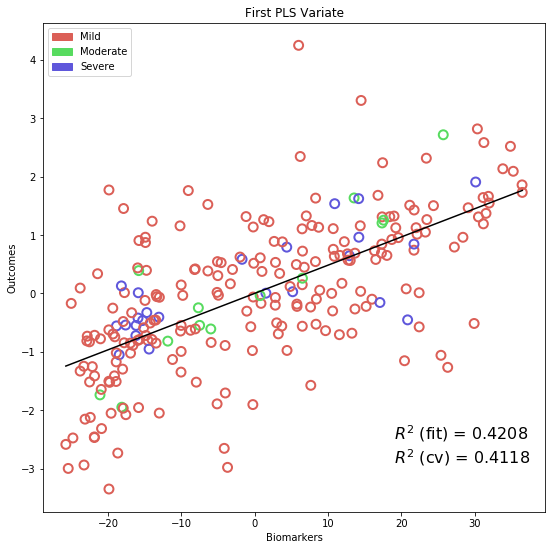

In [62]:
plt.figure(figsize=(9, 9))

cross_decomp_scatter(bm_plsr[:,0], oc_plsr[:,0], labels=gcs_simple, title="First PLS Variate", xlabel="Biomarkers", ylabel="Outcomes")
plt.savefig("pls_raw.pdf")

In [9]:
cca = CCA(n_components=1)
nmf_bm_cca, nmf_oc_cca = cca.fit_transform(nmf_data.biomarkers, nmf_data.outcomes)

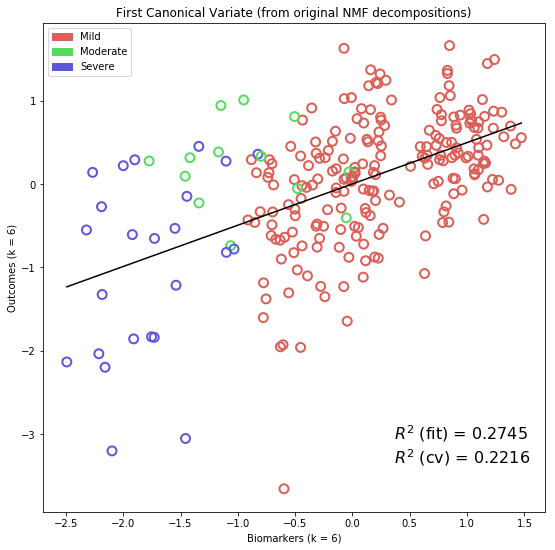

In [61]:
plt.figure(figsize=(9, 9))
cross_decomp_scatter(nmf_bm_cca[:,0], nmf_oc_cca[:,0], labels=gcs_simple, 
                  title="First Canonical Variate (from original NMF decompositions)", 
                  xlabel="Biomarkers (k = %d)" % nmf_data.biomarkers.shape[1], ylabel="Outcomes (k = %d)" % nmf_data.outcomes.shape[1])
plt.savefig("cca_nmf.pdf")

In [28]:
ks = list(range(2,15))
nmf = NMF(beta_loss='kullback-leibler', solver='mu', max_iter=5000, init='random')
minpts = [2, 5, 10, 12]

In [71]:
bm_nmf = list()
bm_rec_err = list()
bm_seed = 4010733382
#bm_seed = 4010733381
print(bm_seed)
for m in minpts:
    uoinmf = UoINMF(ranks=ks, dbscan=HDBSCAN(min_cluster_size=m), nmf=nmf, random_state=bm_seed)
    bm_nmf.append((uoinmf.fit_transform(raw_data.biomarkers), uoinmf))
    print(m, np.sum(uoinmf.bases_samples_labels_ == -1)/len(uoinmf.bases_samples_labels_), bm_nmf[-1][0].shape[1], uoinmf.reconstruction_err_)
    bm_rec_err.append(uoinmf.reconstruction_err_)
    
bm_rec_err = np.array(bm_rec_err)

4010733382
2 0.45384615384615384 186 49.34075086310822
5 0.39903846153846156 9 73.97461773822911
10 0.4326923076923077 5 80.12896113063533
12 0.4375 5 79.9905575467794


In [72]:
oc_nmf = list()
ocin = raw_data.outcomes - np.min(raw_data.outcomes, axis=0)
oc_rec_err = list()

oc_seed = 2505839653
#oc_seed = 2505839652
print(oc_seed)
for m in minpts:
    uoinmf = UoINMF(ranks=ks, dbscan=HDBSCAN(min_cluster_size=m), nmf=nmf, random_state=oc_seed)
    oc_nmf.append((uoinmf.fit_transform(ocin), uoinmf))
    print(m, np.sum(uoinmf.bases_samples_labels_ == -1)/len(uoinmf.bases_samples_labels_), oc_nmf[-1][0].shape[1], uoinmf.reconstruction_err_)
    oc_rec_err.append(uoinmf.reconstruction_err_)
    
oc_rec_err = np.array(oc_rec_err)

2505839653
2 0.2932692307692308 187 256.49319528752426
5 0.45865384615384613 14 549.0763561841242
10 0.4932692307692308 9 656.0152327935391
12 0.5086538461538461 9 652.245274771222


In [73]:
corr = np.zeros((len(bm_nmf), len(oc_nmf)), dtype=np.float)

for ii, bm in enumerate(bm_nmf):
    for jj, oc in enumerate(oc_nmf):
        #print(bm.shape[1], oc.shape[1])
        bm_cca, oc_cca = CCA(n_components=1).fit_transform(bm[0], oc[0])
        corr[ii, jj], pval = sps.pearsonr(bm_cca, oc_cca)

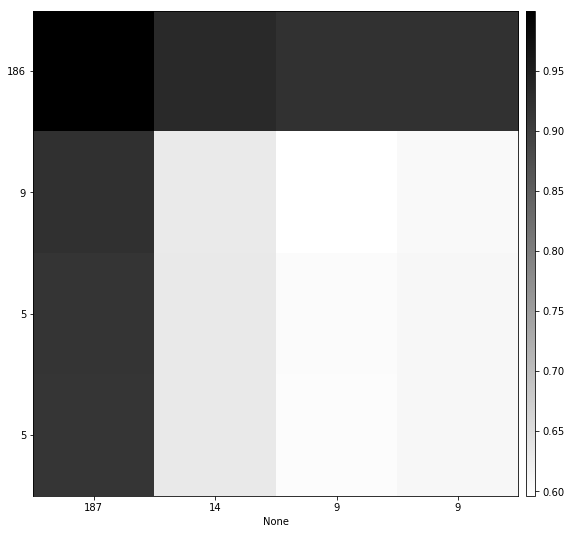

In [74]:
plt.figure(figsize=(9,9))
from activ.analytics import heatmap
x = [_[0].shape[1] for _ in bm_nmf]
y = [_[0].shape[1] for _ in oc_nmf]
ret = heatmap(corr, x, y)

### Plot optimal CCA NMF embeddings

Choose one less than the best for each Biomarkers and Outcomes, since the best is not significantly smaller than the input data.

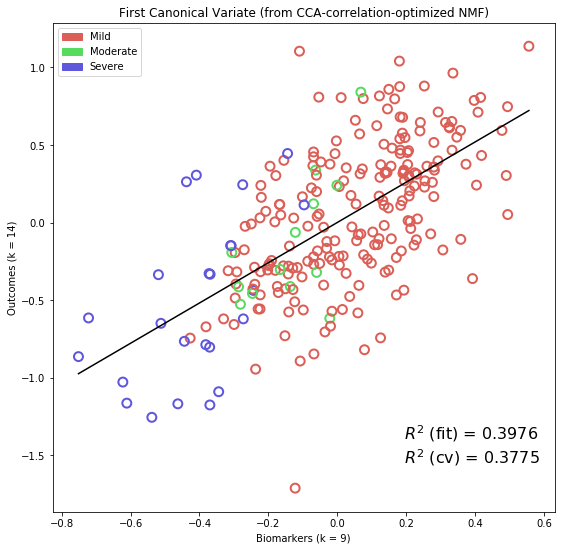

In [77]:
opt_bm_cca, opt_oc_cca = CCA(n_components=1).fit_transform(bm_nmf[1][0], oc_nmf[1][0])

plt.figure(figsize=(9, 9))
cross_decomp_scatter(opt_bm_cca[:,0], opt_oc_cca[:,0], labels=gcs_simple, 
                  title="First Canonical Variate (from CCA-correlation-optimized NMF)", 
                  xlabel="Biomarkers (k = %d)" % bm_nmf[1][0].shape[1], ylabel="Outcomes (k = %d)" % oc_nmf[1][0].shape[1])

plt.savefig("cca_nmf_optimized.pdf")

<Figure size 648x648 with 0 Axes>

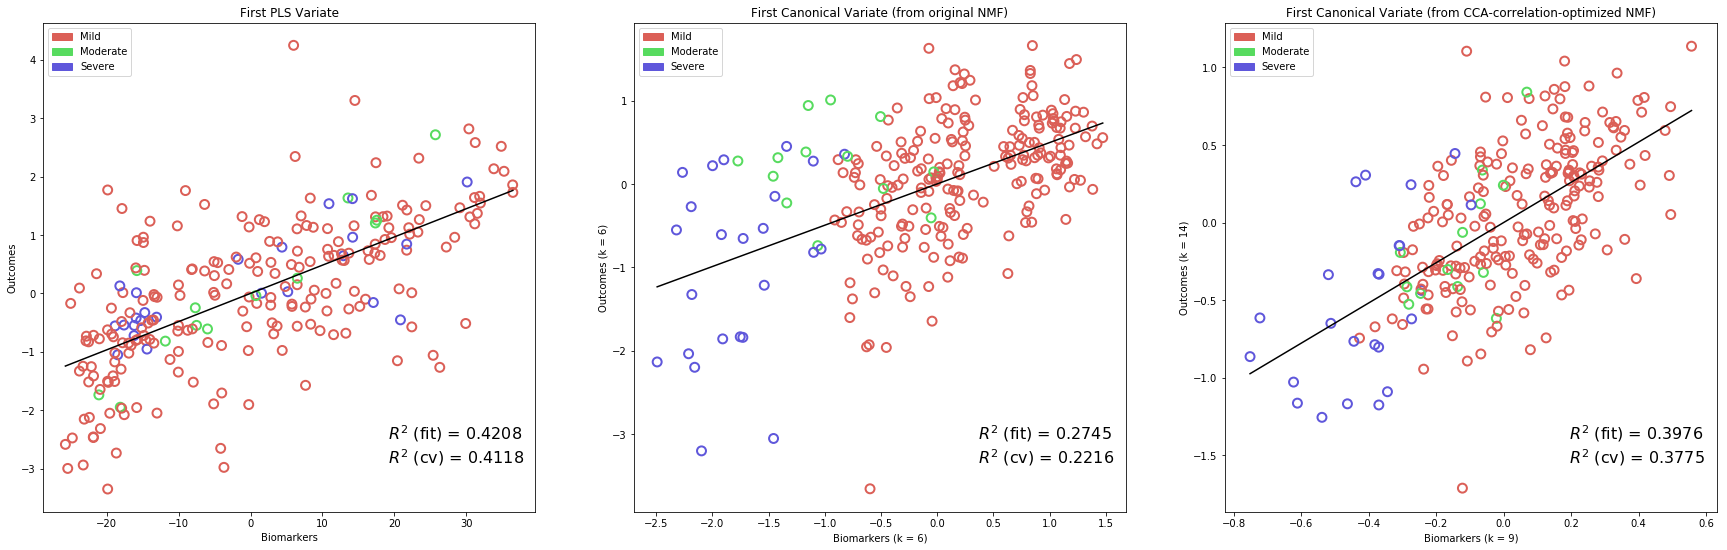

In [78]:
plt.figure(figsize=(9,9))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(30)
fig.set_figheight(9)

cross_decomp_scatter(bm_plsr[:,0], oc_plsr[:,0], labels=gcs_simple, 
                     title="First PLS Variate", 
                     xlabel="Biomarkers", ylabel="Outcomes", ax=ax1)

cross_decomp_scatter(nmf_bm_cca[:,0], nmf_oc_cca[:,0], labels=gcs_simple, 
                  title="First Canonical Variate (from original NMF)", 
                  xlabel="Biomarkers (k = %d)" % nmf_data.biomarkers.shape[1], ylabel="Outcomes (k = %d)" % nmf_data.outcomes.shape[1], 
                  ax=ax2)
                     
cross_decomp_scatter(opt_bm_cca[:,0], opt_oc_cca[:,0], labels=gcs_simple, 
                     title="First Canonical Variate (from CCA-correlation-optimized NMF)", 
                     xlabel="Biomarkers (k = %d)" % bm_nmf[1][0].shape[1], ylabel="Outcomes (k = %d)" % oc_nmf[1][0].shape[1], 
                     ax=ax3)
plt.savefig("cross_decomp_results.pdf")